<a href="https://colab.research.google.com/github/vpinilla001/DeepAnT/blob/master/Copia_de_unsupervised_timeseries_anomaly_detection2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Data** : **eighty-years-of-canadian-climate-data/Canadian_climate_history.csv**

In [ ]:
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler
import time
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os

data_file = "/content/repsol.csv"
MODEL_SELECTED = "deepant" # Possible Values ['deepant', 'lstmae']
LOOKBACK_SIZE = 100 #Ventana temporal de 10 puntos
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        data_file = os.path.join(dirname, filename)

In [ ]:
def read_modulate_data(data_file):
    """
        Data ingestion : Function to read and formulate the data
    """
    data = pd.read_csv(data_file)
    data.fillna(data.mean(), inplace=True)
    data = data.iloc[:,[0,4]]
    df = data.copy()
    data.set_index("Fecha", inplace=True)
    data.index = pd.to_datetime(data.index)
    return data, df

In [ ]:
def data_pre_processing(df):
    """
        Data pre-processing : Function to create data for Model

        X: Ventanas temporales
        Y: Próximo dato de la ventana temporal --> El dato a predecir
        T: Donde acaba cada ventana temporal Xi (fecha)
    """
    try:
        scaled_data = MinMaxScaler(feature_range = (0, 1))
        data_scaled_ = scaled_data.fit_transform(df)
        df.loc[:,:] = data_scaled_
        _data_ = df.to_numpy(copy=True)
        X = np.zeros(shape=(df.shape[0]-LOOKBACK_SIZE,LOOKBACK_SIZE,df.shape[1]))
        Y = np.zeros(shape=(df.shape[0]-LOOKBACK_SIZE,df.shape[1]))
        timesteps = []
        for i in range(LOOKBACK_SIZE-1, df.shape[0]-1):
            timesteps.append(df.index[i])
            Y[i-LOOKBACK_SIZE+1] = _data_[i+1]
            for j in range(i-LOOKBACK_SIZE+1, i+1):
                X[i-LOOKBACK_SIZE+1][LOOKBACK_SIZE-1-i+j] = _data_[j]
        return X,Y,timesteps
    except Exception as e:
        print("Error while performing data pre-processing : {0}".format(e))
        return None, None, None

In [ ]:
class DeepAnT(torch.nn.Module):
    """
        Model : Class for DeepAnT model
    """
    def __init__(self, LOOKBACK_SIZE, DIMENSION):
        super(DeepAnT, self).__init__()
        self.conv1d_1_layer = torch.nn.Conv1d(in_channels=LOOKBACK_SIZE, out_channels=16, kernel_size=1)
        self.relu_1_layer = torch.nn.ReLU()
        self.maxpooling_1_layer = torch.nn.MaxPool1d(kernel_size=1)
        self.conv1d_2_layer = torch.nn.Conv1d(in_channels=16, out_channels=16, kernel_size=1)
        self.relu_2_layer = torch.nn.ReLU()
        self.maxpooling_2_layer = torch.nn.MaxPool1d(kernel_size=1)
        self.flatten_layer = torch.nn.Flatten()
        self.dense_1_layer = torch.nn.Linear(16, 40)
        self.relu_3_layer = torch.nn.ReLU()
        self.dropout_layer = torch.nn.Dropout(p=0.25)
        self.dense_2_layer = torch.nn.Linear(40, DIMENSION)
        
    def forward(self, x):
        x = self.conv1d_1_layer(x)
        x = self.relu_1_layer(x)
        x = self.maxpooling_1_layer(x)
        x = self.conv1d_2_layer(x)
        x = self.relu_2_layer(x)
        x = self.maxpooling_2_layer(x)
        x = self.flatten_layer(x)
        x = self.dense_1_layer(x)
        x = self.relu_3_layer(x)
        x = self.dropout_layer(x)
        return self.dense_2_layer(x)

In [ ]:
class LSTMAE(torch.nn.Module):
    """
        Model : Class for LSTMAE model
    """
    def __init__(self, LOOKBACK_SIZE, DIMENSION):
        super(LSTMAE, self).__init__()
        self.lstm_1_layer = torch.nn.LSTM(DIMENSION, 128, 1)
        self.dropout_1_layer = torch.nn.Dropout(p=0.2)
        self.lstm_2_layer = torch.nn.LSTM(128, 64, 1)
        self.dropout_2_layer = torch.nn.Dropout(p=0.2)
        self.lstm_3_layer = torch.nn.LSTM(64, 64, 1)
        self.dropout_3_layer = torch.nn.Dropout(p=0.2)
        self.lstm_4_layer = torch.nn.LSTM(64, 128, 1)
        self.dropout_4_layer = torch.nn.Dropout(p=0.2)
        self.linear_layer = torch.nn.Linear(128, DIMENSION)
        
    def forward(self, x):
        x, (_,_) = self.lstm_1_layer(x)
        x = self.dropout_1_layer(x)
        x, (_,_) = self.lstm_2_layer(x)
        x = self.dropout_2_layer(x)
        x, (_,_) = self.lstm_3_layer(x)
        x = self.dropout_3_layer(x)
        x, (_,_) = self.lstm_4_layer(x)
        x = self.dropout_4_layer(x)
        return self.linear_layer(x)

In [ ]:
def make_train_step(model, loss_fn, optimizer):
    """
        Computation : Function to make batch size data iterator
    """
    def train_step(x, y):
        model.train()
        yhat = model(x)
        loss = loss_fn(y, yhat)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        return loss.item()
    return train_step

In [ ]:
def compute(X,Y):
    """
        Computation : Find Anomaly using model based computation 
    """
    if str(MODEL_SELECTED) == "lstmae":
        model = LSTMAE(10,26)
        criterion = torch.nn.MSELoss(reduction='mean')
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
        train_data = torch.utils.data.TensorDataset(torch.tensor(X.astype(np.float32)), torch.tensor(X.astype(np.float32)))
        train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=32, shuffle=False)
        train_step = make_train_step(model, criterion, optimizer)
        for epoch in range(30):
            loss_sum = 0.0
            ctr = 0
            for x_batch, y_batch in train_loader:
                loss_train = train_step(x_batch, y_batch)
                loss_sum += loss_train
                ctr += 1
            print("Training Loss: {0} - Epoch: {1}".format(float(loss_sum/ctr), epoch+1))
        hypothesis = model(torch.tensor(X.astype(np.float32))).detach().numpy()
        loss = np.linalg.norm(hypothesis - X, axis=(1,2))
        return loss.reshape(len(loss),1)
    elif str(MODEL_SELECTED) == "deepant":
        model = DeepAnT(LOOKBACK_SIZE,26)
        criterion = torch.nn.MSELoss(reduction='mean')
        optimizer = torch.optim.Adam(list(model.parameters()), lr=1e-5)
        train_data = torch.utils.data.TensorDataset(torch.tensor(X.astype(np.float32)), torch.tensor(Y.astype(np.float32)))
        train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=32, shuffle=False)
        train_step = make_train_step(model, criterion, optimizer)
        for epoch in range(50):
            loss_sum = 0.0
            ctr = 0
            for x_batch, y_batch in train_loader:
                loss_train = train_step(x_batch, y_batch)
                loss_sum += loss_train
                ctr += 1
            print("Training Loss: {0} - Epoch: {1}".format(float(loss_sum/ctr), epoch+1))
        hypothesis = model(torch.tensor(X.astype(np.float32))).detach().numpy()
        loss = np.linalg.norm(hypothesis - Y, axis=1)
        return loss.reshape(len(loss),1)
    else:
        print("Selection of Model is not in the set")
        return None

In [ ]:
data, _data = read_modulate_data(data_file)
X,Y,T = data_pre_processing(data)
loss = compute(X, Y)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([32, 26])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([22, 26])) that is different to the input size (torch.Size([22, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Training Loss: 0.3833545826535584 - Epoch: 1
Training Loss: 0.16117148402172682 - Epoch: 2
Training Loss: 0.06672889383831149 - Epoch: 3
Training Loss: 0.04220810395290907 - Epoch: 4
Training Loss: 0.031946973711481606 - Epoch: 5
Training Loss: 0.025557853176955653 - Epoch: 6
Training Loss: 0.021065452188071796 - Epoch: 7
Training Loss: 0.018005221841392072 - Epoch: 8
Training Loss: 0.01563197911810787 - Epoch: 9
Training Loss: 0.013874593835725492 - Epoch: 10
Training Loss: 0.012711816093979393 - Epoch: 11
Training Loss: 0.011510167361103892 - Epoch: 12
Training Loss: 0.01065751130264336 - Epoch: 13
Training Loss: 0.00990465314248774 - Epoch: 14
Training Loss: 0.009401838774264164 - Epoch: 15
Training Loss: 0.008884258844726614 - Epoch: 16
Training Loss: 0.008455533312509377 - Epoch: 17
Training Loss: 0.008200354863978526 - Epoch: 18
Training Loss: 0.007873117839804038 - Epoch: 19
Training Loss: 0.007585378769800697 - Epoch: 20
Training Loss: 0.007367555615076983 - Epoch: 21
Training 

In [ ]:
loss_df = pd.DataFrame(loss, columns = ["loss"])
loss_df.index = T
loss_df.index = pd.to_datetime(loss_df.index)
loss_df["timestamp"] = T
loss_df["timestamp"] = pd.to_datetime(loss_df["timestamp"])

In [ ]:
loss_df

,loss,timestamp
2018-08-02 02:36:00,0.096991,2018-08-02 02:36:00
2018-08-02 02:52:00,0.089391,2018-08-02 02:52:00
2018-08-02 03:08:00,0.095134,2018-08-02 03:08:00
2018-08-02 03:24:00,0.201963,2018-08-02 03:24:00
2018-08-02 03:40:00,0.548200,2018-08-02 03:40:00
...,...,...
2020-02-25 08:44:00,0.166730,2020-02-25 08:44:00
2020-02-25 09:00:00,0.410210,2020-02-25 09:00:00
2020-02-25 09:16:00,0.628861,2020-02-25 09:16:00
2020-02-25 09:32:00,0.247902,2020-02-25 09:32:00


In [ ]:
data

,1200_V
Fecha,
2018-08-01 00:12:00,0.712124
2018-08-01 00:28:00,0.708662
2018-08-01 00:44:00,0.705306
2018-08-01 01:00:00,0.703068
2018-08-01 01:16:00,0.702962
...,...
2020-02-25 09:00:00,0.650650
2020-02-25 09:16:00,0.650064
2020-02-25 09:32:00,0.650597


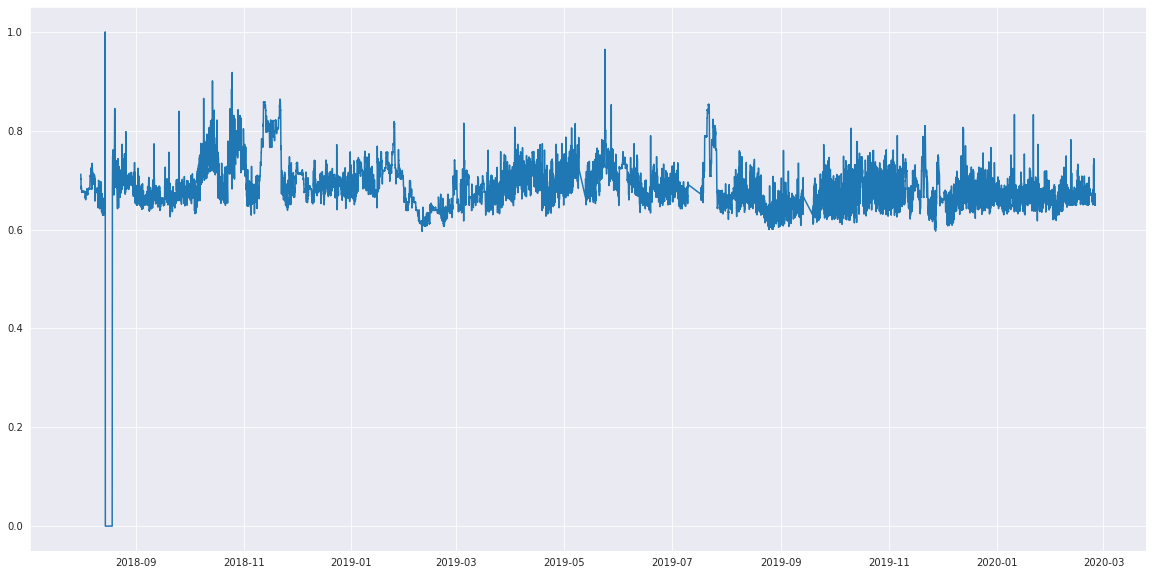

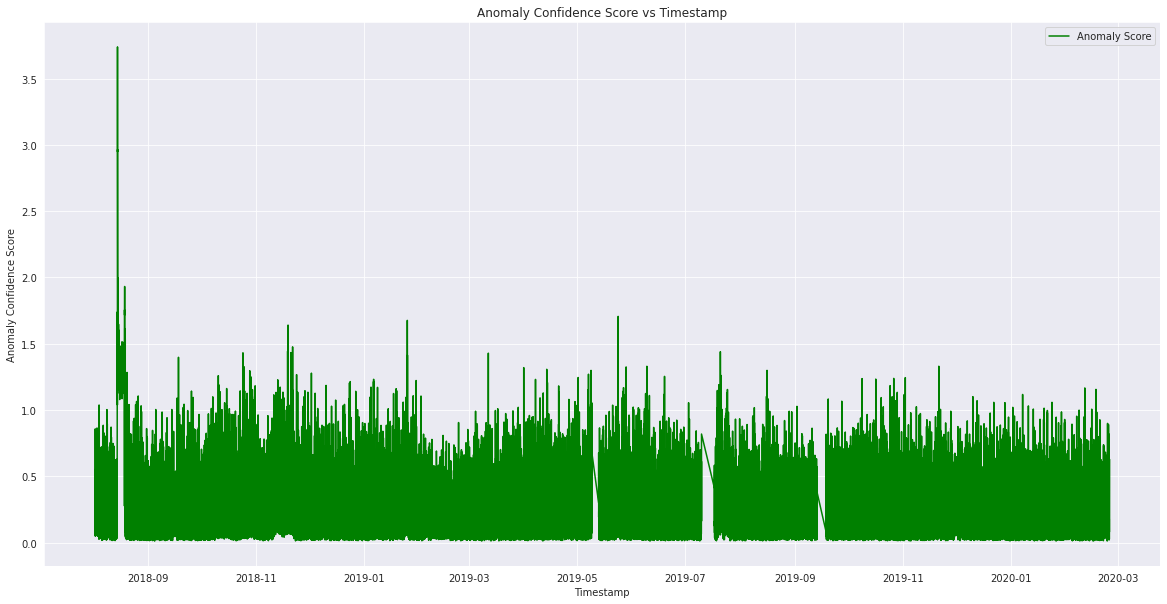

In [ ]:
"""
    Visualization 
"""
plt.figure(figsize=(20,10))
sns.set_style("darkgrid")
plt.plot(data)

plt.figure(figsize=(20,10))
ax = sns.lineplot(x="timestamp", y="loss", data=loss_df, color='g', label="Anomaly Score")
ax.set_title("Anomaly Confidence Score vs Timestamp")
ax.set(ylabel="Anomaly Confidence Score", xlabel="Timestamp")
plt.legend()

In [ ]:
!pip install saxpy

     |████████████████████████████████| 184kB 4.3MB/s 
     |████████████████████████████████| 235kB 13.7MB/s 
  Created wheel for saxpy: filename=saxpy-1.0.1.dev167-cp36-none-any.whl size=17671 sha256=5cfe56035e44967a6639d476a64f4f22a90b029ec2766804e33e649081071446
  Stored in directory: /root/.cache/pip/wheels/68/d1/a0/a2a4f96eb82607654bc45f00479af34ddd7c45be9096b8e63c
Successfully built saxpy
ERROR: datascience 0.10.6 has requirement coverage==3.7.1, but you'll have coverage 5.2.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: coveralls 0.5 has requirement coverage<3.999,>=3.6, but you'll have coverage 5.2.1 which is incompatible.
ERROR: pytest-cov 2.10.0 has requirement pytest>=4.6, but you'll have pytest 3.6.4 which is incompatible.
  Found existing installation: coverage 3.7.1
    Uninstalling coverage-3.7.1:
      Successfully uninstalled coverage-3.7.1


In [ ]:
import numpy as np
from saxpy.hotsax import find_discords_hotsax
from numpy import genfromtxt
# dd = genfromtxt("/content/repsol.csv", delimiter=',')  
discords = find_discords_hotsax(np.array(data.iloc[:5000,0]), num_discords=15)
discords

[(1147, 9.999999999999998),
 (1596, 8.935951982062313),
 (4876, 8.473598901184905),
 (4368, 8.254594867269002),
 (2676, 8.12735811167131),
 (3350, 8.053853757827588),
 (3598, 7.983509332912914),
 (4183, 7.965882600629543),
 (2004, 7.844299719040077),
 (3467, 7.7429308166342965),
 (3919, 7.720780872062734),
 (4769, 7.514042441687173),
 (2105, 7.509102193239344),
 (2937, 7.438675026143406),
 (701, 7.262888318361296)]

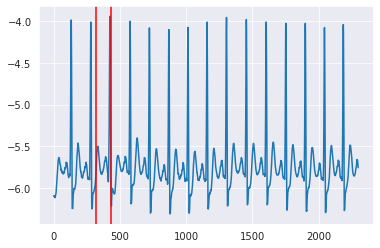

In [ ]:
plt.plot(dd)
plt.axvline(x=430, color = 'red')
plt.axvline(x=318, color = 'red')

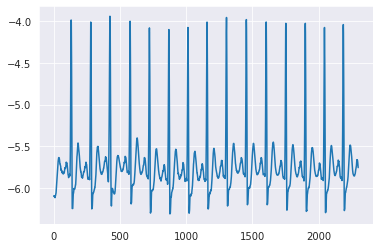

In [ ]:
plt.plot(dd)